# The objective of the assignment is to compute the reliability of a wind turbine blade against fatigue failure in its root section. It requires defining a limit state function and estimating the probability of failure based on different environmental and material variables

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import scipy
from pandas.plotting import scatter_matrix
import seaborn as sns
from windrose import WindroseAxes

## Two datasets are provided: 
 - Hovsore = 10-minute average wind speeds, directions, turbulence at Høvsøre over 10 
years, including timestamp
 - DEL = data of simulated 10-minute realizations of damage 
equivalent loads (DEL) for the DTU 10MW reference wind turbine as function of various external 
conditions, including wind speed, turbulence, wind shear.

In [4]:
# Directory containing the files (current working directory)
current_dir = os.getcwd()  # gets the path of the folder where the code is run
Hovsore_data_filepath = os.path.join(current_dir, 'HovsoreData_Sonic_100m_2004-2013.csv')

# Load Hovsore wind data CSV
Hovsore_data = pd.read_csv(Hovsore_data_filepath)

# Data preparation

## Filtering: Treating the data to remove any outliers(i.e. removing the wind speeds any higher than 45 m/s) 

In [6]:
# Optimization 1: Efficient data cleaning with vectorized operations and interpolation
def clean_data(df):
    # Replacing windspeeds greater than 45 with NaN
    df['Wsp'] = np.where(df['Wsp'] > 45, np.nan, df['Wsp'])
    
    # Replacing turbulence intensity (TI) values with NaN
    df['TI'] = np.where((df['TI'] > 1.0) | (df['TI'] <= 0), pd.NA, df['TI'])
    df['TI,detrend'] = np.where(df['TI,detrend'] <= 1.5, np.nan, df['TI,detrend'])
    # Using interpolation instead of backward fill to handle missing data
    df_cleaned = df.interpolate(method='linear', limit_direction='both')
    
    # Creating a new feature 'SigmaU' as the product of Wsp and TI
    df_cleaned['SigmaU'] = df_cleaned['Wsp'] * df_cleaned['TI']
    
    return df_cleaned.dropna()

# Apply data cleaning on the dataset
Hovsore_clean_data = clean_data(Hovsore_data)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_8100\3974587436.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_cleaned = df.interpolate(method='linear', limit_direction='both')


In [7]:
'''
Hovsore_clean = Hovsore_data
# Replacing windspeeds greater than 45 and turbulence intensity greater than 0.8 or less than 0 with NaN
Hovsore_clean.loc[Hovsore_clean['Wsp'] > 45, 'Wsp'] = pd.NA
Hovsore_clean['TI'] = np.where((Hovsore_clean['TI'] > 1.0) | (Hovsore_clean['TI'] <= 0),
                               pd.NA, Hovsore_clean['TI'])

# Using backward fill to fill NaN values in the dataframe
Hovsore_clean_data = Hovsore_clean.bfill()
Hovsore_clean_data['SigmaU'] = Hovsore_clean_data['Wsp'] * Hovsore_clean_data['TI']
'''
Hovsore_clean_data

,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir,SigmaU
0,200410010000,9.9196,0.0181,47.3466,346.7130,346.7130,0.8440,343.893,349.044,0.179545
1,200410010020,9.5073,0.0145,47.3466,346.9852,346.9852,0.6518,344.751,348.949,0.137856
2,200410010030,9.5274,0.021,47.3466,346.9152,346.9151,0.7949,343.754,350.588,0.200075
3,200410010040,9.9498,0.0253,47.3466,346.3204,346.3204,0.7549,343.971,349.953,0.25173
4,200410010050,10.2376,0.0151,47.3466,345.4185,345.4185,0.6362,343.074,348.960,0.154588
...,...,...,...,...,...,...,...,...,...,...
439507,201308312310,15.6264,0.0773,77.2467,299.8040,299.8043,2.6738,288.901,309.955,1.207921
439508,201308312320,13.7150,0.0576,77.2467,298.0319,298.0315,3.2644,288.643,309.245,0.789984
439509,201308312330,13.4969,0.0797,77.2467,297.7226,297.7242,3.5721,284.827,306.117,1.075703
439510,201308312340,13.4135,0.1034,77.2467,294.6266,294.6243,3.9459,283.195,310.353,1.386956


## Visualization

In [9]:
'''
# Convert the Timestamp column to datetime format
df_fr_plt = Hovsore_clean_data
df_fr_plt['Timestamp'] = pd.to_datetime(df_fr_plt['Timestamp'], format='%Y%m%d%H%M')

# Set Timestamp as index for easier plotting
df_fr_plt.set_index('Timestamp', inplace=True)

# Create a single figure with subplots to avoid multiple figure creations
fig, ax = plt.subplots(4, 1, figsize=(15, 20))

# Plot Wind Speed
ax[0].plot(df_fr_plt.index, df_fr_plt['Wsp'], color='tab:blue', alpha=0.7)
ax[0].set_title('Wind Speed Over Time')
ax[0].set_ylabel('Wind Speed (m/s)')
ax[0].grid(True)

# Plot Turbulence Intensity
ax[1].plot(df_fr_plt.index, df_fr_plt['TI'], color='tab:orange', alpha=0.7)
ax[1].set_title('Turbulence Intensity Over Time')
ax[1].set_ylabel('Turbulence Intensity')
ax[1].grid(True)

# Wind Rose Plot
ax2 = WindroseAxes.from_ax(fig=fig, rect=[0.1, 0.5, 0.8, 0.4])
ax2.bar(df_fr_plt['MeanDir'], df_fr_plt['Wsp'], opening=0.8, edgecolor='white')
ax2.set_title('Wind Rose: Distribution of Wind Directions and Speeds')
ax2.set_legend(title='Wind Speed (m/s)')

# Scatter Plot: Wind Speed vs Turbulence Intensity
sns.scatterplot(ax=ax[2], x='Wsp', y='TI', data=df_fr_plt.sample(frac=0.1), alpha=0.5)
ax[2].set_title('Scatter Plot: Wind Speed vs Turbulence Intensity')
ax[2].set_xlabel('Wind Speed (m/s)')
ax[2].set_ylabel('Turbulence Intensity')
ax[2].grid(True)

# Histograms for Wind Speed and Turbulence Intensity
sns.histplot(ax=ax[3], data=df_fr_plt['Wsp'], kde=False, bins=50, color='blue', edgecolor='black')
ax[3].set_title('Histogram: Wind Speed Distribution')
ax[3].set_xlabel('Wind Speed (m/s)')
ax[3].set_ylabel('Frequency')
ax[3].grid(True)

plt.tight_layout()
plt.show()

# Separate histogram for Turbulence Intensity
plt.figure(figsize=(10, 6))
sns.histplot(df_fr_plt['TI'], kde=False, bins=50, color='orange', edgecolor='black')
plt.title('Histogram: Turbulence Intensity Distribution')
plt.xlabel('Turbulence Intensity')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()
'''

"\n# Convert the Timestamp column to datetime format\ndf_fr_plt = Hovsore_clean_data\ndf_fr_plt['Timestamp'] = pd.to_datetime(df_fr_plt['Timestamp'], format='%Y%m%d%H%M')\n\n# Set Timestamp as index for easier plotting\ndf_fr_plt.set_index('Timestamp', inplace=True)\n\n# Create a single figure with subplots to avoid multiple figure creations\nfig, ax = plt.subplots(4, 1, figsize=(15, 20))\n\n# Plot Wind Speed\nax[0].plot(df_fr_plt.index, df_fr_plt['Wsp'], color='tab:blue', alpha=0.7)\nax[0].set_title('Wind Speed Over Time')\nax[0].set_ylabel('Wind Speed (m/s)')\nax[0].grid(True)\n\n# Plot Turbulence Intensity\nax[1].plot(df_fr_plt.index, df_fr_plt['TI'], color='tab:orange', alpha=0.7)\nax[1].set_title('Turbulence Intensity Over Time')\nax[1].set_ylabel('Turbulence Intensity')\nax[1].grid(True)\n\n# Wind Rose Plot\nax2 = WindroseAxes.from_ax(fig=fig, rect=[0.1, 0.5, 0.8, 0.4])\nax2.bar(df_fr_plt['MeanDir'], df_fr_plt['Wsp'], opening=0.8, edgecolor='white')\nax2.set_title('Wind Rose: Dis

## Fit a marginal Weibull distribution to the wind speed

In [11]:
# WIND SPEED DISTRIBUTION FIT
# Weibull distribution fit using the max-likelihood method
Wsp0 = np.asarray(Hovsore_clean_data['Wsp'])

WeibLikelihoodFunc = lambda theta: -np.sum( stats.weibull_min.logpdf(Wsp0,c = theta[1],scale=theta[0]) )
Weib0 = scipy.optimize.minimize(WeibLikelihoodFunc,[2,1])

WeibullA = Weib0.x[0]
Weibullk = Weib0.x[1]

print('Distribution parameters using the max-likelihood method: A = ' + str(Weib0.x[0]) + ', k = ' + str(Weib0.x[1]))

Distribution parameters using the max-likelihood method: A = 9.983755853223187, k = 2.033112206114492


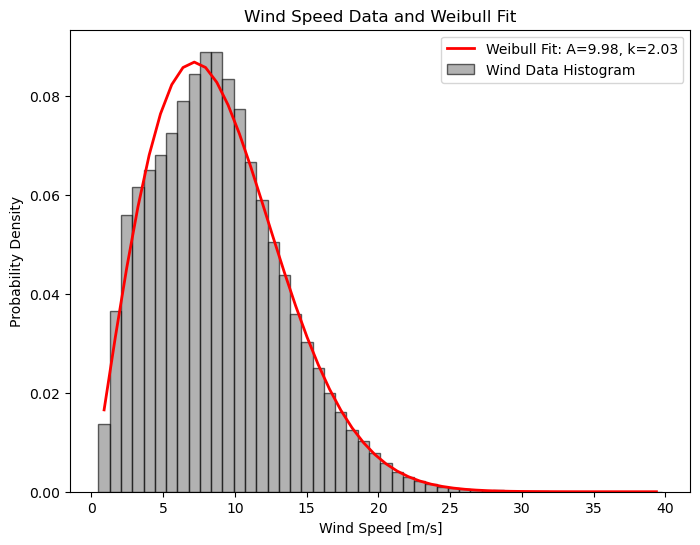

In [12]:
# Create a histogram of the wind speed data
counts1, bin_edges1 = np.histogram(Wsp0, bins=50, density=True)
bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2

# Calculate the Weibull distribution for the estimated parameters
pdf_weibull_fit1 = stats.weibull_min.pdf(bin_centers1, c=Weibullk, scale=WeibullA)

# Plot the histogram and the fitted Weibull distribution
plt.figure(figsize=(8, 6))
plt.bar(bin_centers1, counts1, width=np.diff(bin_edges1), alpha=0.6, color='grey', label="Wind Data Histogram", edgecolor='black')
plt.plot(bin_centers1, pdf_weibull_fit1, 'r-', label=f'Weibull Fit: A={WeibullA:.2f}, k={Weibullk:.2f}', lw=2)
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Probability Density')
plt.title('Wind Speed Data and Weibull Fit')
plt.legend()
plt.show()


## Fit a conditional LogNormal distribution to the turbulence, considering quadratic dependence of the mean turbulence to the wind speed

In [14]:
# Helper function - Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y

# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.array(mu, dtype=np.float64)  # Ensure mu is an array
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x = np.maximum(x, 1e-8)  # Avoid log(0) errors
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x = np.maximum(x, 1e-8)  # Avoid log(0) errors
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

In [15]:
# CONDITION DISTRIBUTION OF TURBULENCE - BASED ON DATA BINNING
WspBinEdges = np.arange(3.5,33.5,1)
WspBinCenters = WspBinEdges[:-1] + 0.5

MuSigmaBinned = np.zeros(len(WspBinCenters))
SigmaSigmaBinned = np.zeros(len(WspBinCenters))

nData = len( Hovsore_clean_data['Wsp'])


# Per wind speed
for iWsp in range(len(WspBinCenters)):
    WspBinSelection = ( Hovsore_clean_data['Wsp'] > WspBinEdges[iWsp]) & ( Hovsore_clean_data['Wsp'] <= WspBinEdges[iWsp + 1])
    MuSigmaBinned[iWsp] = np.mean(Hovsore_clean_data.loc[WspBinSelection,'SigmaU'])
    SigmaSigmaBinned[iWsp] = np.std(Hovsore_clean_data.loc[WspBinSelection,'SigmaU'])
    
Mudatax = WspBinCenters[~np.isnan(MuSigmaBinned)]
Mudatay = MuSigmaBinned[~np.isnan(MuSigmaBinned)]
SigmaSigmaBinned = SigmaSigmaBinned[~np.isnan(MuSigmaBinned)]

# Use polyfit (for example np.polyfit). Which order works well - 0, 1, or 2?
# You can choose the order of the polynomial (0 for constant, 1 for linear, 2 for quadratic)
pMu = np.polyfit(Mudatax, Mudatay, deg=2)


SigmaSigmaRef = np.mean(SigmaSigmaBinned)
        
MuSigmaFunc = lambda u: np.polyval(pMu, u)
SigmaSigmaFunc = lambda u: SigmaSigmaRef #np.ones(shape = np.shape(u)) * SigmaSigmaRef


In [16]:
N = 10000
Urand = stats.weibull_min.rvs(c= Weibullk, scale = WeibullA, size = N)
MuSigmaUrand = MuSigmaFunc(Urand)
Sigma_Urand = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.rand(N), MuSigmaUrand, Sigma_Urand)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_8100\652484324.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].plot(WspBinCenters, SigmaSigmaBinned, '-o', label='Standard Deviation per Bin', linewidth=2, marker='s', markersize=6)


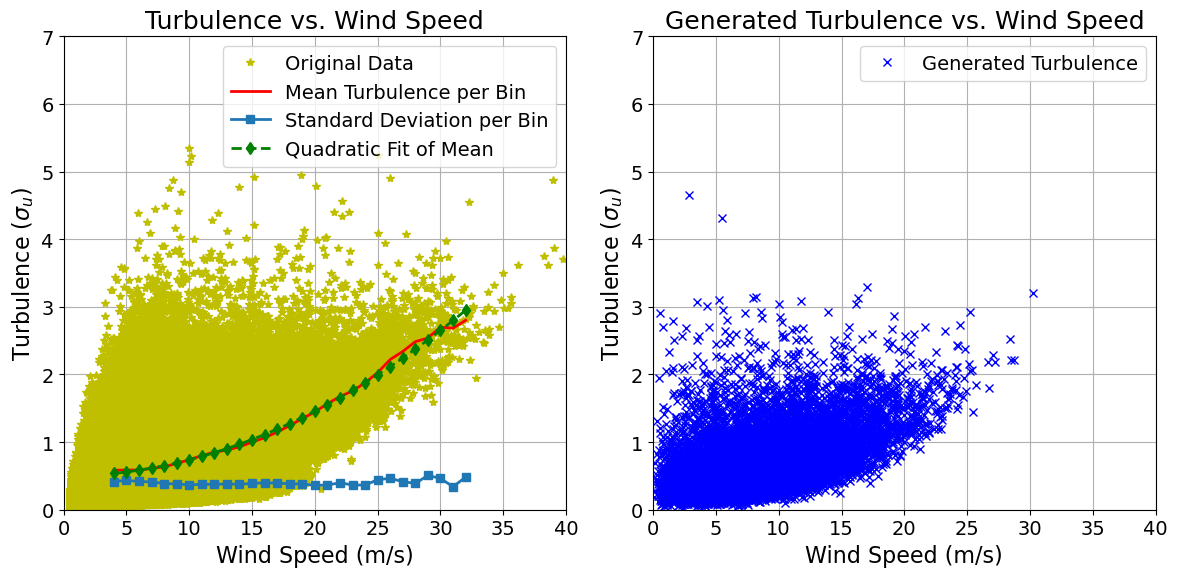

In [17]:
# PLOT TURBULENCE INCLUDING DISTRIBUTION PARAMETERS
# Adjusting plot settings
plt.rcParams.update({
    'font.size': 14,  # Set the font size for text in the plots
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Left plot: Wind speed vs Turbulence
ax[0].plot(Hovsore_clean_data['Wsp'], Hovsore_clean_data['SigmaU'], '*y', label='Original Data')
ax[0].plot(WspBinCenters, MuSigmaBinned, '-r', label='Mean Turbulence per Bin', linewidth=2)
ax[0].plot(WspBinCenters, SigmaSigmaBinned, '-o', label='Standard Deviation per Bin', linewidth=2, marker='s', markersize=6)
ax[0].plot(WspBinCenters, MuSigmaFunc(WspBinCenters), '--g', label='Quadratic Fit of Mean', linewidth=2, marker='d', markersize=6)
ax[0].set_xlim([0, 40])
ax[0].set_ylim([0, 7])
ax[0].set_xlabel('Wind Speed (m/s)')
ax[0].set_ylabel(r'Turbulence ($\sigma_u$)')
ax[0].set_title('Turbulence vs. Wind Speed')
ax[0].legend()
ax[0].grid(True)

# Right plot: Generated turbulence vs wind speed
ax[1].plot(Urand, SigmaUrand, 'xb', label='Generated Turbulence')
ax[1].set_xlim([0, 40])
ax[1].set_ylim([0, 7])
ax[1].set_xlabel('Wind Speed (m/s)')
ax[1].set_ylabel(r'Turbulence ($\sigma_u$)')
ax[1].set_title('Generated Turbulence vs. Wind Speed')
ax[1].legend()
ax[1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## Determine the probability distribution of the wind climate uncertainty variable $X_w$ by analyzing the wind data through bootstrapping, further incorporating a 1% uncertainty for wind speed measurement and 1% for the joint-distribution fit.

In [19]:
Hovsore_clean_data

,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir,SigmaU
0,200410010000,9.9196,0.0181,47.3466,346.7130,346.7130,0.8440,343.893,349.044,0.179545
1,200410010020,9.5073,0.0145,47.3466,346.9852,346.9852,0.6518,344.751,348.949,0.137856
2,200410010030,9.5274,0.021,47.3466,346.9152,346.9151,0.7949,343.754,350.588,0.200075
3,200410010040,9.9498,0.0253,47.3466,346.3204,346.3204,0.7549,343.971,349.953,0.25173
4,200410010050,10.2376,0.0151,47.3466,345.4185,345.4185,0.6362,343.074,348.960,0.154588
...,...,...,...,...,...,...,...,...,...,...
439507,201308312310,15.6264,0.0773,77.2467,299.8040,299.8043,2.6738,288.901,309.955,1.207921
439508,201308312320,13.7150,0.0576,77.2467,298.0319,298.0315,3.2644,288.643,309.245,0.789984
439509,201308312330,13.4969,0.0797,77.2467,297.7226,297.7242,3.5721,284.827,306.117,1.075703
439510,201308312340,13.4135,0.1034,77.2467,294.6266,294.6243,3.9459,283.195,310.353,1.386956


Estimated Mean of Wind Speeds: 8.989841258674776
Standard Deviation of Wind Speeds: 0.5725756329559468
95% Confidence Interval: (8.020895187703315, 10.056025352631764)


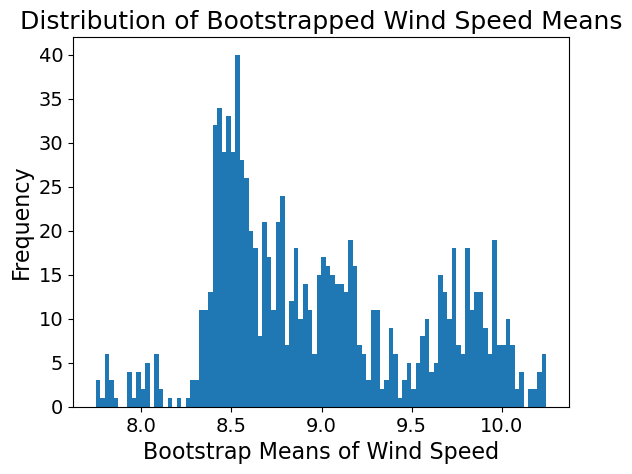

Final Mean of X_W: 1.0069318122188704
Final Standard Deviation of X_W: 0.5200000000000032


In [20]:
data = Hovsore_clean_data['Wsp']
wind_speeds = data

# Function for bootstrapping using continuous periods
def bootstrap_continuous(data, n_iterations=1000, sample_size=None, ci=95):
    if sample_size is None:
        sample_size = len(data) // 10  # Default sample size to a tenth of the data length

    bootstrapped_means = []
    for i in range(n_iterations):
        # Randomly select a starting point for the sample
        start_idx = np.random.randint(0, len(data) - sample_size)
        resample = data[start_idx:start_idx + sample_size]
        # Calculate the mean and add it to the list
        bootstrapped_means.append(np.mean(resample))

    # Incorporate the 1% uncertainty for wind speed measurement and joint-distribution fit
    bootstrapped_means = np.array(bootstrapped_means) * (1 + 0.02)  # Adding 1% uncertainty

    # Calculate confidence intervals
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(bootstrapped_means, lower_percentile)
    upper_bound = np.percentile(bootstrapped_means, upper_percentile)

    return {
        'mean': np.mean(bootstrapped_means),
        'std_dev': np.std(bootstrapped_means),
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'all_means': bootstrapped_means
    }

# Perform bootstrap analysis on wind speed data
bootstrap_result = bootstrap_continuous(wind_speeds)

# Display bootstrap statistics
print(f"Estimated Mean of Wind Speeds: {bootstrap_result['mean']}")
print(f"Standard Deviation of Wind Speeds: {bootstrap_result['std_dev']}")
print(f"{95}% Confidence Interval: ({bootstrap_result['lower_bound']}, {bootstrap_result['upper_bound']})")

# Plotting the distribution of bootstrapped means
plt.hist(bootstrap_result['all_means'], bins=100)
plt.xlabel('Bootstrap Means of Wind Speed')
plt.ylabel('Frequency')
plt.title('Distribution of Bootstrapped Wind Speed Means')
plt.show()

mean_xw_orig = bootstrap_result['mean']
std_dev_xw_orig = bootstrap_result['std_dev']

# Step 2: Calculate scaling factor to make mean = 1
scaling_factor = 1 / mean_xw_orig

# Step 3: Scale the wind speed data to have a mean of 1
scaled_wind_speeds = wind_speeds * scaling_factor

# Step 4: Calculate the desired standard deviation based on CoV
desired_cov = 0.52  # Example CoV value (you can determine this based on the requirement)
desired_std_dev = desired_cov * 1  # Since mean = 1, standard deviation = CoV

# Step 5: Calculate the current standard deviation of scaled data
current_std_dev = np.std(scaled_wind_speeds)

# Step 6: Adjust the standard deviation to match the desired CoV
adjusted_wind_speeds = scaled_wind_speeds * (desired_std_dev / current_std_dev)

# Verify the mean and standard deviation
mean_xw_final = np.mean(adjusted_wind_speeds)
std_dev_xw_final = np.std(adjusted_wind_speeds)

print(f"Final Mean of X_W: {mean_xw_final}")  # Should be approximately 1
print(f"Final Standard Deviation of X_W: {std_dev_xw_final}")  # Should be approximately desired_std_dev


# Set up a load surrogate model 𝑀_𝑥 that maps the 10-minute DELs as function of 𝑢,𝜎_𝑢 and 𝛼;

## data of simulated 10-minute realizations of damage equivalent loads (DEL) for the DTU 10MW reference wind turbine as function of various external conditions, including wind speed, turbulence, wind shear.
- Input variables in sheet1
- Load data in sheet2

In [22]:
DEL_data_filepath = os.path.join(current_dir, 'ML_ExampleDataSet.xlsx')
# Load DEL data from Excel
input_data = pd.read_excel(DEL_data_filepath,'InputVariables')  # Read sheet1
load_data = pd.read_excel(DEL_data_filepath,'LoadResults')  # Read sheet1
input_data.drop(columns = ['MannL', 'MannGamma', 'VeerDeltaPhi'], inplace = True) # Remove unnecessary columns

Now we have two data frames, which contain respectively the input variables and the dependent variables for our machine learning problem. However, we are not sure whether these are appropriately synchronized, i.e., whether the indexes of the two data frames match. Pandas provides several means of comparing data columns and merging data frames. One way of doing it is with the df.merge() command where df is the name of the data frame. Here we will use an "inner" merging, which means that only data entries which exist in both data frames to be merged, are being retained. In this way the merging also acts as a filter to eliminate entries where some of the data may not be available. In supervised machine learning, useful information is provided by from data entry pairs where both the input variables and the dependent variable are valid. If one finds it more convenient to keep the input feature and dependent variable data frames separate, a similar synchronization can be done by element-wise comparison of the data frames, using the df.where() command.

In [24]:
AllInputData = input_data.where(input_data['Sample_No']==load_data['PointNo'])
AllTargetData = load_data.where(load_data['PointNo']==input_data['Sample_No'])
AllInputData.drop(columns = 'Sample_No', inplace = True)
AllTargetData.drop(columns = 'PointNo', inplace = True)
nsamples = AllInputData['U'].count() # Find the total number of data points in the data frame
FeatureNames = AllInputData.columns.values
DependentVariableNames = AllTargetData.columns.values
print('Input: ', FeatureNames)
print('Dependent variable names: ', DependentVariableNames)

Input:  ['U' 'SigmaU' 'Alpha']
Dependent variable names:  ['Tower_top_fore_aft_M_x' 'Tower_top_side2side_M_y'
 'Tower_base_fore_aft_M_x' 'Tower_base_side2side_M_y' 'Yaw_moment_M_z'
 'Main_shaft_torsion_M_z' 'Blade_root_flapwise_M_x'
 'Blade_root_edgewise_M_y']


For computing the probability of fatigue failure in the wind turbine blade root, it is more appropriate to focus on flapwise moments rather than edgewise. Here’s why:

1. Flapwise Bending: The flapwise bending moments primarily come from aerodynamic loading due to wind forces acting perpendicular to the blade plane. This is the main source of fatigue loading that a wind turbine blade experiences throughout its operation. The continuous action of wind causes the blade to bend back and forth in a flapwise direction, leading to higher fatigue stresses. Thus, fatigue analysis for failure is typically more affected by these flapwise loads.

2. Edgewise Bending: The edgewise moments are mainly influenced by gravity and rotational forces acting along the plane of the blade. While they do contribute to fatigue, their influence on fatigue failure is generally less compared to flapwise loads.

Therefore, for a procedure to compute the probability of fatigue failure of a wind turbine blade root, it is advisable to use the flapwise moments (Blade_root_flapwise_M_x) as the target for modeling the fatigue damage and performing reliability analysis.

### Fitting a polynomial model

In [27]:
TargetName = 'Blade_root_flapwise_M_x'

# Building a design matrix for a polynomial of 3rd order
def DesignMatrixO3(X):
    ndim = X.shape[1] 
    npoints = X.shape[0]
    m = int(((ndim-1)/2)*ndim)
    Xmatrix = np.zeros((npoints,3*ndim + 3*m + 1))
    columncount = 0
    Xmatrix[:,columncount] = np.ones(npoints)
    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]

    for i in range(ndim -1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*X[:,j]

    for i in range(ndim):
        columncount+= 1
        Xmatrix[:,columncount] = X[:,i]**2

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = (X[:,i]**2)*X[:,j]

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*(X[:,j]**2)

    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]**3
    return Xmatrix


def PredictPolyO3(X,Alsq):
    Xmatrix = DesignMatrixO3(X)
    Y = np.dot(Xmatrix,Alsq)
    return Y


In [28]:
# MAKE A 3-RD ORDER POLYNOMIAL FIT TO THE DATA USING THE HELPER FUNCTIONS GIVEN ABOVE
Y1 = AllTargetData['Blade_root_flapwise_M_x']
X = AllInputData.values

# BEGIN CODE HERE
Xmatrix = DesignMatrixO3(X)

XX = np.dot(Xmatrix.T, Xmatrix)
XY = np.dot(Xmatrix.T, Y1)
Alsq = np.linalg.lstsq(XX,XY)[0]
Alsq.shape

Ypred_O3 = PredictPolyO3(X,Alsq)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_8100\4235009165.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alsq = np.linalg.lstsq(XX,XY)[0]


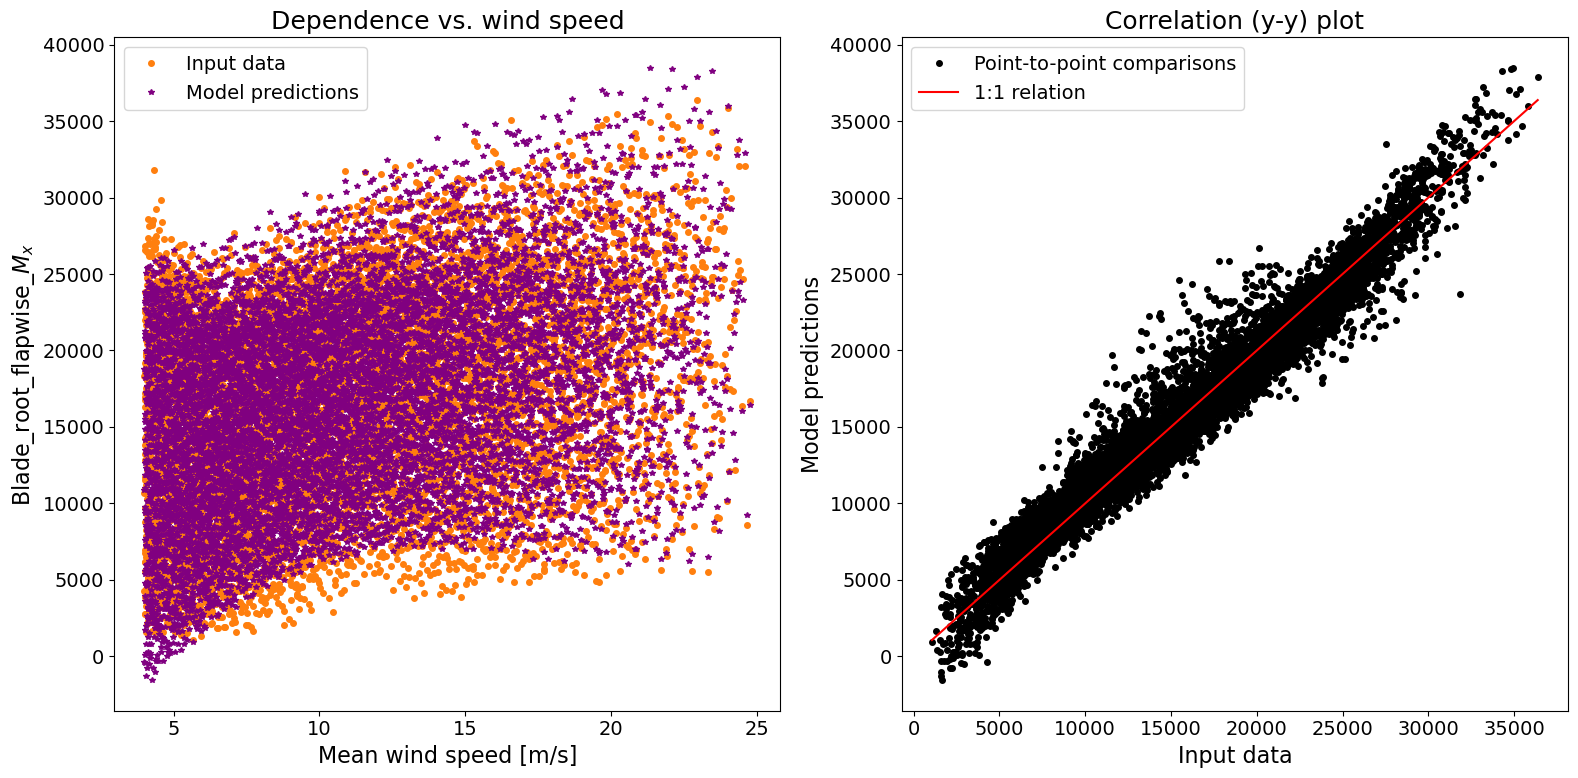

In [29]:
plt.rc('font', size=14) 
fig2a,axs2a = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs2a[0], title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Blade_root_flapwise_$M_x$')
plt.setp(axs2a[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs2a[0].plot(AllInputData['U'],AllTargetData['Blade_root_flapwise_M_x'],'o',markersize = 4,color = 'C1')
axs2a[0].plot(AllInputData['U'],Ypred_O3,'*',markersize = 4,color = 'purple')
axs2a[0].legend(['Input data','Model predictions'])
axs2a[1].plot(AllTargetData['Blade_root_flapwise_M_x'],Ypred_O3,'ok',markersize = 4)
axs2a[1].plot(np.array([np.min(AllTargetData['Blade_root_flapwise_M_x']), np.max(AllTargetData['Blade_root_flapwise_M_x'])]),\
             np.array([np.min(AllTargetData['Blade_root_flapwise_M_x']), np.max(AllTargetData['Blade_root_flapwise_M_x'])]),'-r')
axs2a[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

### Fitting an Artificial Neural Network

In [31]:
import sklearn
import sklearn.neural_network

In [32]:
Mx_model = sklearn.neural_network.MLPRegressor()

# Split the data into training and testing sets
Xscaler = sklearn.preprocessing.StandardScaler()
Yscaler = sklearn.preprocessing.StandardScaler()
Xscaler = Xscaler.fit(AllInputData)
Yscaler = Yscaler.fit(AllTargetData['Blade_root_flapwise_M_x'].values.reshape(-1, 1))

TrainTestRatio = 0.8
N = len(AllInputData)
Xtrain = Xscaler.transform(AllInputData.values[:int(N*TrainTestRatio),:])
Xtest = Xscaler.transform(AllInputData.values[int(N*TrainTestRatio):,:])

Ytrain = Yscaler.transform(AllTargetData['Blade_root_flapwise_M_x'].values[:int(N*TrainTestRatio)].reshape(-1,1))
Ytest = Yscaler.transform(AllTargetData['Blade_root_flapwise_M_x'].values[int(N*TrainTestRatio):].reshape(-1,1))

C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [33]:
Mx_model.set_params(learning_rate_init = 0.01, activation = 'relu',tol = 1e-6,n_iter_no_change = 10, hidden_layer_sizes = (100,100), validation_fraction = 0.1)
Mx_model.fit(Xtrain,Ytrain)

C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(100, 100), learning_rate_init=0.01, tol=1e-06)

In [34]:
print( 'Train set r-square: ' + str(Mx_model.score(Xtrain,Ytrain)))
print( 'Test set r-square: ' + str(Mx_model.score(Xtest,Ytest)))

Train set r-square: 0.9712029919472764
Test set r-square: 0.9707553667547638


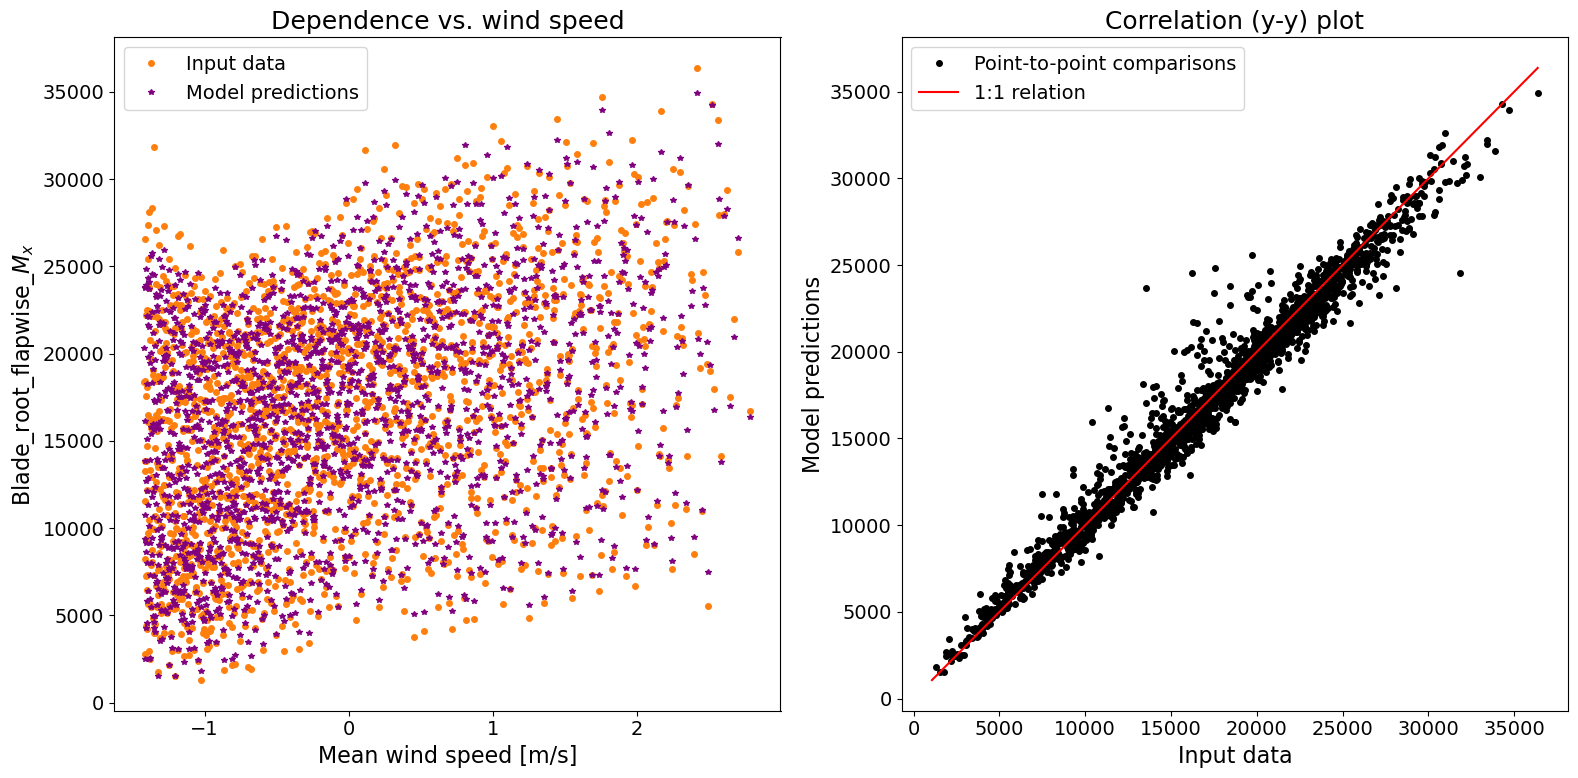

In [35]:
Yout = Yscaler.inverse_transform(Mx_model.predict(Xtrain).reshape(-1, 1))
Yout_test = Yscaler.inverse_transform(Mx_model.predict(Xtest).reshape(-1, 1))

plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Blade_root_flapwise_$M_x$')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,0],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,0],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData['Blade_root_flapwise_M_x']), np.max(AllTargetData['Blade_root_flapwise_M_x'])]),\
             np.array([np.min(AllTargetData['Blade_root_flapwise_M_x']), np.max(AllTargetData['Blade_root_flapwise_M_x'])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

In [36]:
# Setting up a function
Yfunc = lambda X: Yscaler.inverse_transform(Mx_model.predict(Xscaler.transform(X)).reshape(-1, 1)) 

# Yfunc(AllInputData)

# Set up a routine to compute the total lifetime fatigue damage as function of ($𝑋_𝑀$,$𝑋_𝑊$) by integrating 
the short-term damage predictions from th  load surrogate model over the joint distribution of
external conditions; 

In [38]:
# Lifetime-equivalent loads: option 1: mini-Monte Carlo

import openturns as ot

N_samples = 10000

# sN curve paramiters
m = 3 #Fatigue S-N curve slope
k = 4*10**12 #Fatigue strength normalization factor

#uncertanty inputs
delta_mean = 1
cov_delta = 0.3  
sigma_delta = delta_mean * cov_delta
delta = LogNormDist(2, np.random.rand(N_samples), delta_mean, sigma_delta)  # Delta (Uncertain material fatigue capacity)
xm_mean = 1
cov_xm = 0.2
sigma_xm = xm_mean * cov_xm 
Xm = NormalDist(2, np.random.rand(N_samples), xm_mean, sigma_xm)             # X_M (Loads model uncertainty)
# from bootstraping in step 2
Xw = NormalDist(2, np.random.rand(N_samples), mean_xw_final, std_dev_xw_final)

Xin = np.array([delta.ravel(), Xm.ravel(),Xw.ravel()]).T


<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Bruger\AppData\Local\Temp\ipykernel_8100\3668479520.py:57: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_U$')


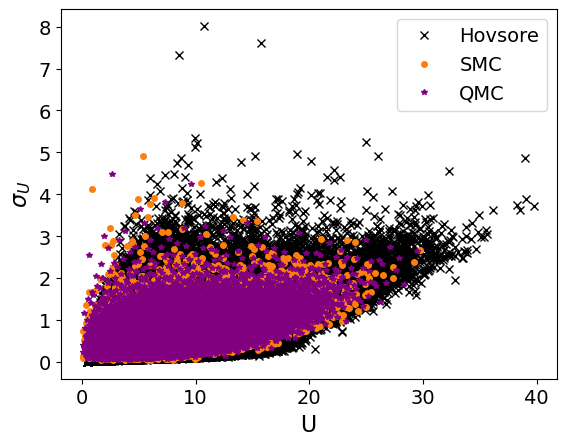

C:\Users\Bruger\AppData\Local\Temp\ipykernel_8100\3668479520.py:61: RuntimeWarning: divide by zero encountered in divide
  LDEL_QMC_noUncertanty = (1/(np.arange(N_samples))*np.cumsum((Yfunc(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Bruger\AppData\Local\Temp\ipykernel_8100\3668479520.py:63: RuntimeWarning: divide by zero encountered in divide
  LDEL_QMC = (1/(np.arange(N_samples))*np.cumsum((Xin[:,1].T*Yfunc(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


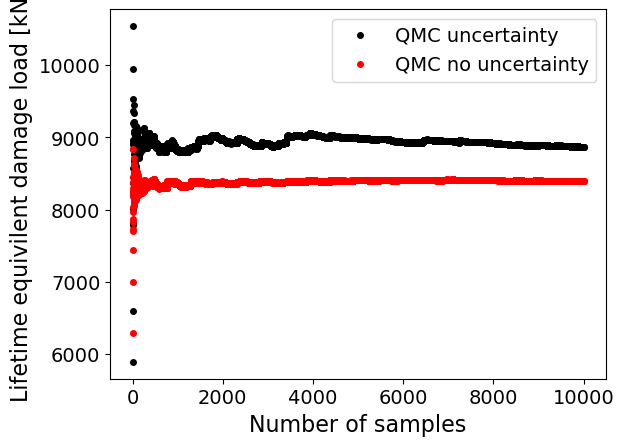

In [39]:
# Function to generate random wind shear exponent alpha for an array of wind speeds
def generate_wind_shear_alpha(u):
    """
    Generates wind shear exponent (alpha) from a normal distribution for each wind speed in u.

    Parameters:
    u (array-like): Array of wind speeds.

    Returns:
    alpha (array): Randomly generated values of the wind shear exponent corresponding to wind speeds.
    """
    mean_alpha = 0.1  # Mean of the normal distribution
    
    # Calculate the standard deviation for each wind speed in the array (std = min(1, 1/u))
    std_alpha = np.minimum(1, 1 / u)
    
    # Generate normally distributed random variables for alpha with corresponding std for each wind speed
    alpha = np.random.normal(mean_alpha, std_alpha)
    
    return alpha


ot.RandomGenerator.SetSeed(0)  # Set seed for reproducibility
dim = 2  # Dimensions for (X_m, X_w)

uniform_distribution = ot.ComposedDistribution([ot.Uniform(0., 1.)] * dim)

# Crude Monte-Carlo
SMC = uniform_distribution.getSample(N_samples)

U_SMC= stats.weibull_min.ppf(SMC[:,0], c=Weibullk, loc=0, scale = WeibullA) #stats.weibull_min.rvs(c= Weibullk, scale = WeibullA, size = 10000)
MuSigmaU_SMC = MuSigmaFunc(U_SMC)
SigmaSigma_SMC = SigmaSigmaFunc(U_SMC)
SigmaU_SMC = LogNormDist(2, SMC[:,1], MuSigmaU_SMC, SigmaSigma_SMC)
# wind shear alpha
alpha_SMC = generate_wind_shear_alpha(U_SMC)

# Quasi- Monte Carlo (QMC)
QMCexperiment = ot.LowDiscrepancyExperiment(ot.SobolSequence(), uniform_distribution, N_samples, False)
SQMC = QMCexperiment.generate()
SQMC = np.asarray(SQMC)#.T

U_QMC = stats.weibull_min.ppf(SQMC[:,0], c=Weibullk, loc=0, scale = WeibullA)
MuSigmaU_QMC = MuSigmaFunc(U_QMC)
SigmaSigma_QMC = SigmaSigmaFunc(U_QMC)
SigmaU_QMC = LogNormDist(2, SQMC[:,1], MuSigmaU_QMC, SigmaSigma_QMC)
# wind shear alpha
alpha_QMC = generate_wind_shear_alpha(U_QMC)

#plot of sigmaU vs U for SMC and QMC
plt.figure()
plt.plot(Hovsore_clean_data['Wsp'],Hovsore_clean_data['SigmaU'],'xk', label = 'Hovsore')
plt.plot(U_SMC,SigmaU_SMC,'o',markersize = 4,color = 'C1', label = 'SMC')
plt.plot(U_QMC,SigmaU_QMC,'*',markersize = 4,color = 'purple', label = 'QMC')
plt.legend()
plt.xlabel('U')
plt.ylabel('$\sigma_U$')
plt.show()

#lifetime equivilent damage loads
LDEL_QMC_noUncertanty = (1/(np.arange(N_samples))*np.cumsum((Yfunc(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)

LDEL_QMC = (1/(np.arange(N_samples))*np.cumsum((Xin[:,1].T*Yfunc(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)

# plot
plt.plot(LDEL_QMC,'o',markersize = 4,color = 'k', label = 'QMC uncertainty')
plt.plot(LDEL_QMC_noUncertanty,'o',markersize = 4,color = 'r', label = 'QMC no uncertainty')
plt.xlabel('Number of samples')
plt.ylabel('Lifetime equivilent damage load [kN]')
plt.legend()


C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Bruger\AppData\Local\Temp\ipykernel_8100\974778675.py:5: RuntimeWarning: divide by zero encountered in divide
  LDamage_QMC = np.cumsum(Y_QMC**3)/(np.arange(N_samples)*5e12)


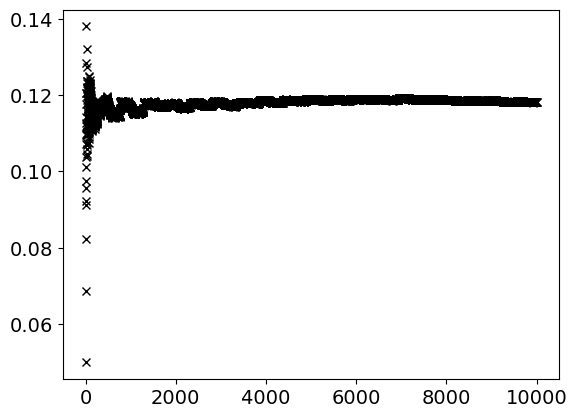

In [40]:
Y_QMC = Yfunc(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T)

LDamage_QMC = np.sum(Y_QMC**3)/(5e12*N_samples)

LDamage_QMC = np.cumsum(Y_QMC**3)/(np.arange(N_samples)*5e12)

plt.plot(LDamage_QMC,'xk')

C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Bruger\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Probability of failure - MC simulation: 0.0
Reliability index - MC simulation: 1.0
Number of failure events observed - MC simulation: 0
Probability of failure - QMC simulation: 0.0
Reliability index - QMC simulation: 1.0
Number of failure events observed- QMC simulation: 0


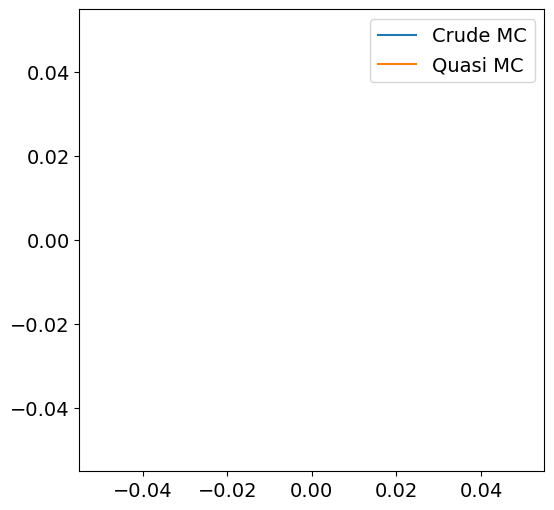

In [41]:
#limit state function
g =lambda x, U, SigmaU, alpha : x[:,0] - 1/(N_samples*k)*np.sum((x[:,1].T*Yfunc(np.array([(x[:,2].T*U),SigmaU,alpha]).T).ravel())**m)
#np.sum((x[:,1].T*Mx_func(np.array([(x[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)
gQMC = g(Xin,U_QMC,SigmaU_QMC,alpha_QMC)
gMC = g(Xin,U_SMC.ravel(),SigmaU_SMC.ravel(),alpha_SMC.ravel())

print('Probability of failure - MC simulation: ' + str(sum(gMC<=0)/N_samples))
print('Reliability index - MC simulation: ' + str(1-sum(gMC<=0)/N_samples))
print('Number of failure events observed - MC simulation: ' + str(sum(gMC <= 0)))

print("Probability of failure - QMC simulation: " + str(sum(gQMC<=0)/N_samples))
print("Reliability index - QMC simulation: " + str(1-sum(gQMC<=0)/N_samples))
print("Number of failure events observed- QMC simulation: " + str(sum(gQMC <= 0)))

betaMChist = stats.norm.ppf(1 - np.cumsum(gMC<=0)/np.arange(1,len(gMC)+1))
betaQMChist = stats.norm.ppf(1 - np.cumsum(gQMC<=0)/np.arange(1,len(gQMC)+1))


fig1,axs1 = plt.subplots(1,1,figsize = (6,6))
axs1.plot(betaMChist, label = 'Crude MC')
axs1.plot(betaQMChist, label = 'Quasi MC')
axs1.legend()
plt.show()